In [57]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

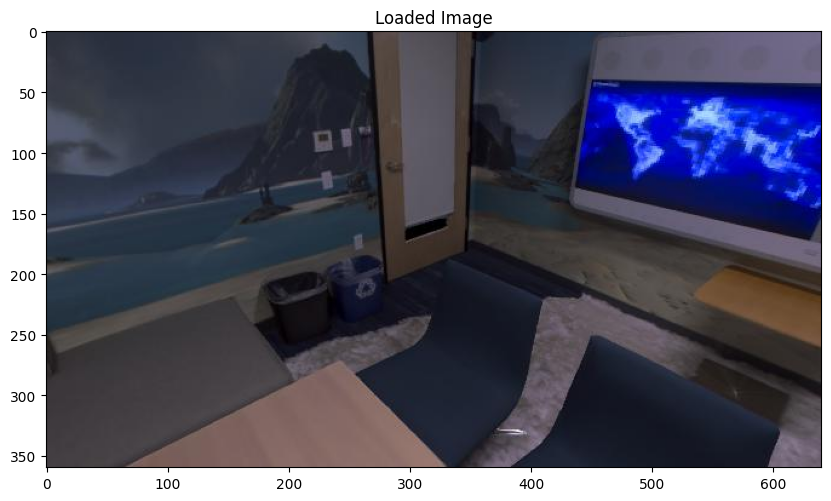

In [83]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

# 加载图像
image_path = "/home/fangj1/Code/nerfstudio-nvsmask3d/tests/0.png"
image = Image.open(image_path).convert('RGB')  # 确保是RGB三通道

# 定义转换
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为tensor，形状为(3, H, W)
])

# 应用转换
image_torch = transform(image)#

# 准备显示
image_display = image_tensor.permute(1, 2, 0)  # 从(C, H, W)转换为(H, W, C)
image_display = image_display.numpy()  # 转换为numpy数组以便matplotlib显示

# 显示图像
plt.figure(figsize=(10, 10))
plt.imshow(image_display)
plt.axis('on')
plt.title("Loaded Image")
plt.show()

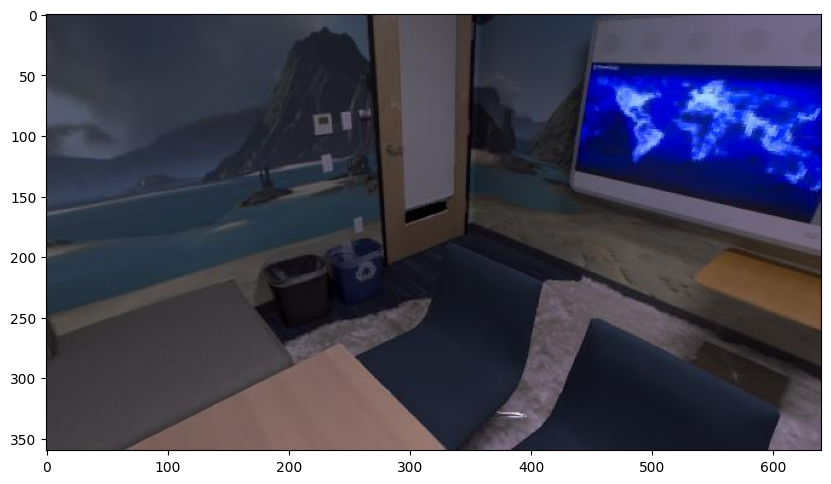

In [106]:
image = cv2.imread('/home/fangj1/Code/nerfstudio-nvsmask3d/tests/0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [107]:
image.shape


(360, 640, 3)

In [60]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/fangj1/Code/nerfstudio-nvsmask3d/nvsmask3d/checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

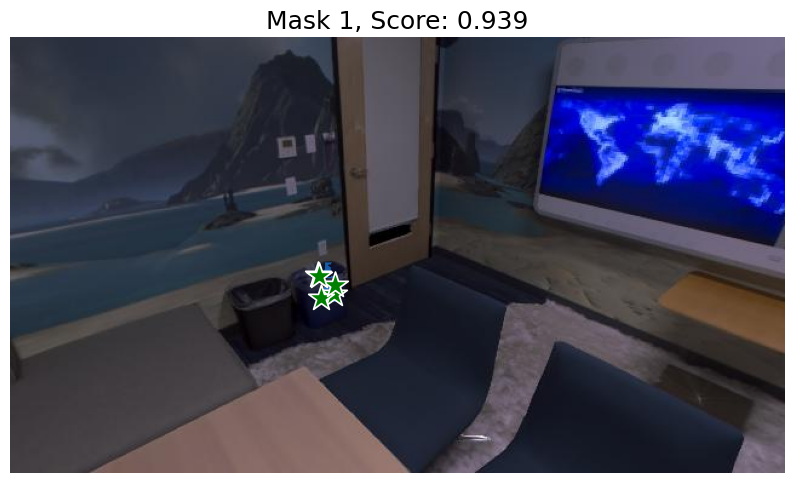

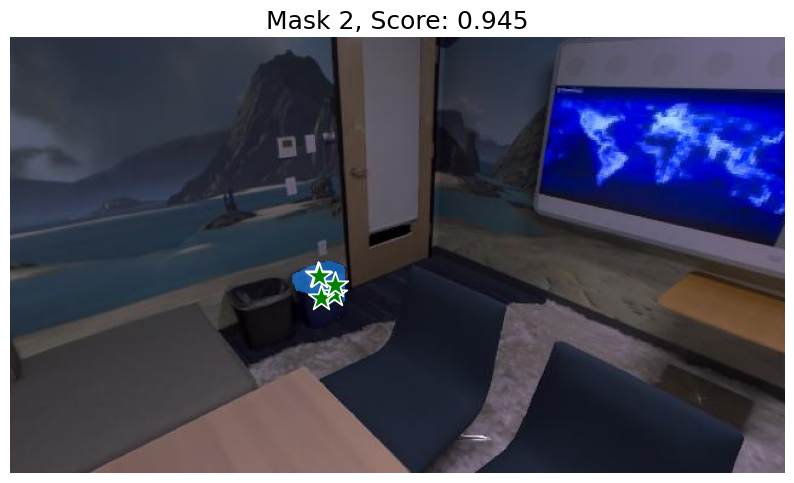

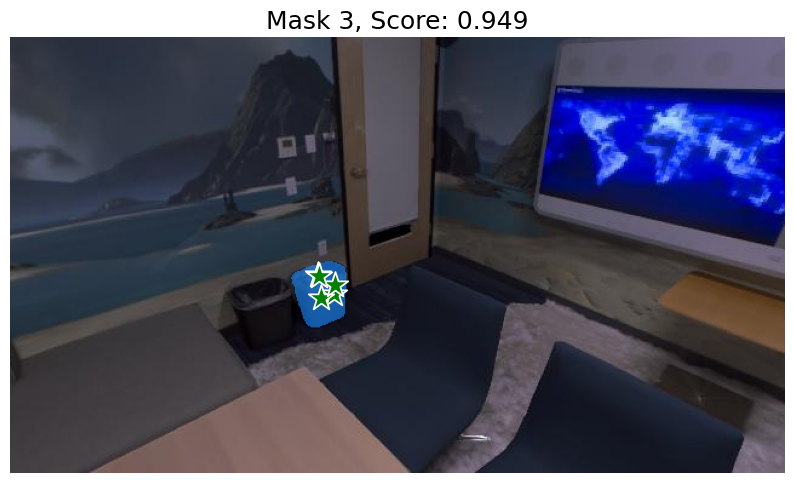

In [108]:
predictor.set_image(image)#(360, 640, 3)
input_point = np.array([[254, 196],
        [267, 212],
        [256, 215],
        [268, 204],
        [255, 197]])
input_label = np.array([1,1,1,1,1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

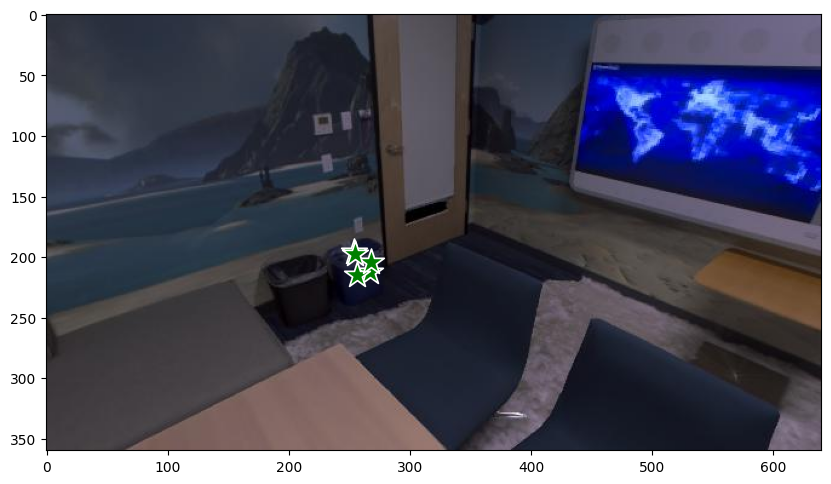

In [62]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [84]:

if image_torch.dim() == 4 and image_torch.shape[0] == 1:
    image_torch = image_torch.squeeze(0)  # Remove batch dimension if present


In [85]:
assert image_torch.dim() == 3, "image_torch must be in CHW format."
assert image_torch.shape[0] == 3, "image_torch must have 3 channels."

In [86]:
original_size = image_torch.shape[1:]  # (H, W)

In [118]:
input_image = (image_torch * 255).unsqueeze(0)
input_image = predictor.transform.apply_image_torch(input_image)  # Resizes the image
input_image = input_image.to(predictor.device)
predictor.set_torch_image(input_image, original_image_size=original_size)

In [119]:
input_image.shape

torch.Size([1, 3, 576, 1024])

In [120]:
transformed_image = predictor.transform.apply_image_torch(input_image)
transformed_image.shape

torch.Size([1, 3, 576, 1024])

In [121]:


point_coords = torch.tensor([[[254, 196],
        [267, 212],
        [256, 215],
        [268, 204],
        [255, 197]]], device='cuda:0')

if point_coords is not None:
    # Transform coordinates
    point_coords = predictor.transform.apply_coords_torch(point_coords, predictor.original_size)
labels_torch = torch.ones((1,5), device = predictor.device)

In [122]:
masks, iou_predictions, low_res_masks = predictor.predict_torch(
            point_coords,
            labels_torch,
        )

In [123]:
masks.shape  # (number_of_masks) x H x W
masks = masks[0].cpu().numpy()

In [124]:
masks.shape
scores = iou_predictions[0].cpu().numpy()

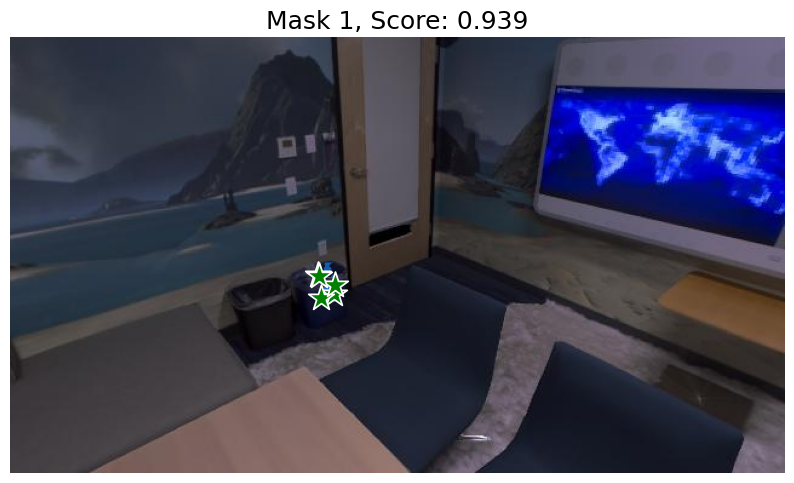

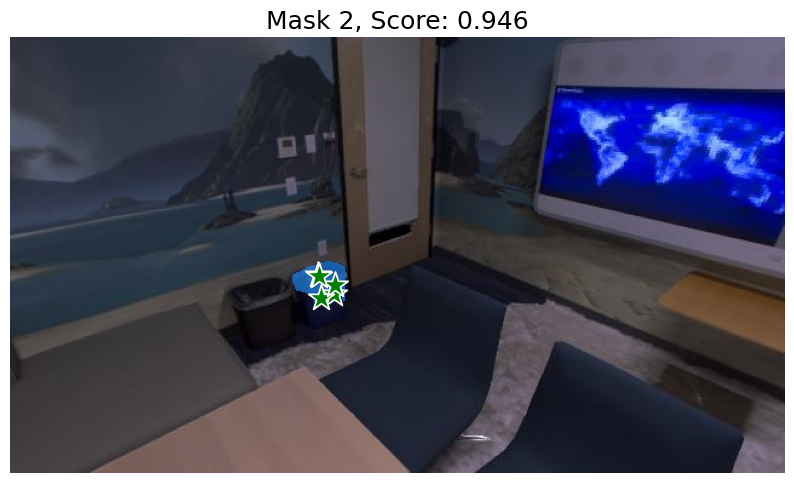

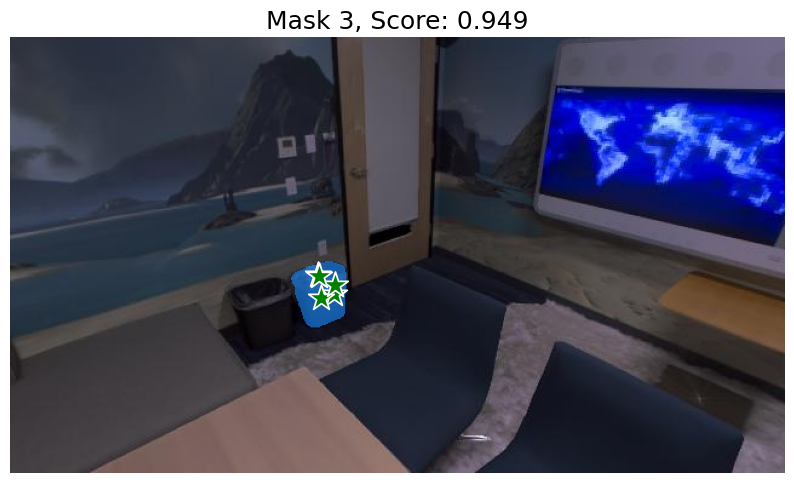

In [125]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 